# Loan Prediction 

### Problem Statement
"Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers."

| Variable             | Description                                   |
|----------------------|-----------------------------------------------|
| Loan_ID              | Unique Loan ID                                |
| Gender               | Male/ Female                                  |
| Married              | Applicant married (Y/N)                       |
| Dependents           | Number of dependents                          |
| Education            | Applicant Education (Graduate/ Under Graduate)|
| Self_Employed        | Self employed (Y/N)                           |
| ApplicantIncome      | Applicant income                              |
| CoapplicantIncome    | Coapplicant income                            |
| LoanAmount           | Loan amount in thousands                      |
| Loan_Amount_Term     | Term of loan in months                        |
| Credit_History       | Credit history meets guidelines               |
| Property_Area        | Urban/ Semi Urban/ Rural                      |
| **Loan_Status**        | (Target) Loan approved (Y/N)                |

`It is a Binary Classification Problem where we have to predict whether a loan would be approved or not`

Steps - 

1. Problem Statement
2. Hypothesis Testing
3. Loading the data
4. Understanding the data
5. Exploratory Data Analysis [EDA]
    - Univariate Analysis
    - Bivariate Analysis
6. Missing value and outlier treatment
7. Evaluation Matrics for classification problems
8. Model Building: I
9. Logistic Regression with stratified k-folds cross validation
10. Feature Engineering
11. Model Building: II
    - Logistic Regression
    - Decission Tree
    - Random Forest
    - XGBoost

### Hypothesis Generation
It is the process of listing out all the possible factors that can affect the outcome.
Below are some of the factors which I think can affect the Loan Approval (dependent variable for this loan prediction problem):

- Salary: Applicants with high income should have more chances of loan approval.
- Previous history: Applicants who have repaid their previous debts should have higher chances of loan approval.
- Loan amount: Loan approval should also depend on the loan amount. If the loan amount is less, chances of loan approval should be high.
- Loan term: Loan for less time period and less amount should have higher chances of approval.
- EMI: Lesser the amount to be paid monthly to repay the loan, higher the chances of loan approval.

### Loading the DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_train_og = pd.read_csv('Dataset/train.csv')
df_test_og = pd.read_csv('Dataset/test.csv')
df_train = df_train_og.copy()
df_test = df_test_og.copy()

In [3]:
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

We have 12 independent variables(features) and 1 target variable - 'Loan_Status' in the train dataset.

In [4]:
df_test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

We have similar features in the test dataset except the target variable 'Loan_Status'.

In [5]:
df_train.shape, df_test.shape

((614, 13), (367, 12))

We have 614 rows and 13 columns in train dataset and 367 rows and 12 columns in test dataset.

### EDA - Univariate Analysis

#### Target Variable

In [6]:
df_train['Loan_Status'].value_counts(dropna=False)

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [7]:
df_train['Loan_Status'].value_counts(normalize=True,dropna=False)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

<Axes: xlabel='Loan_Status'>

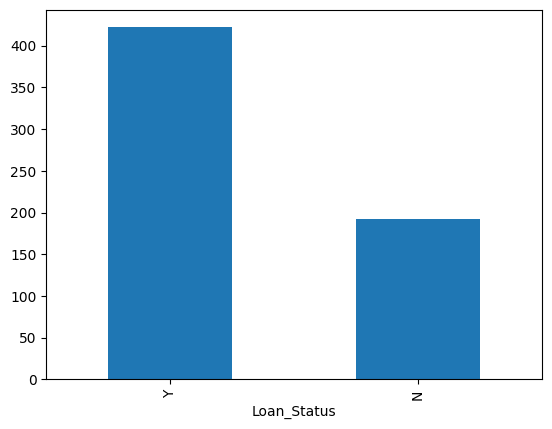

In [8]:
df_train['Loan_Status'].value_counts(dropna=False).plot.bar()

The loan of 422 (~69%) peoples out of 614 was approved.

Now lets visualize each variable separately. Different types of variables are Categorical, ordinal and numerical.

- Categorical features: These features have categories (Gender, Married, Self_Employed, Credit_History, Loan_Status)
- Ordinal features: Variables in categorical features having some order involved (Dependents, Education, Property_Area)
- Numerical features: These features have numerical values (ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term)


#### Independent Variable (Categorical)

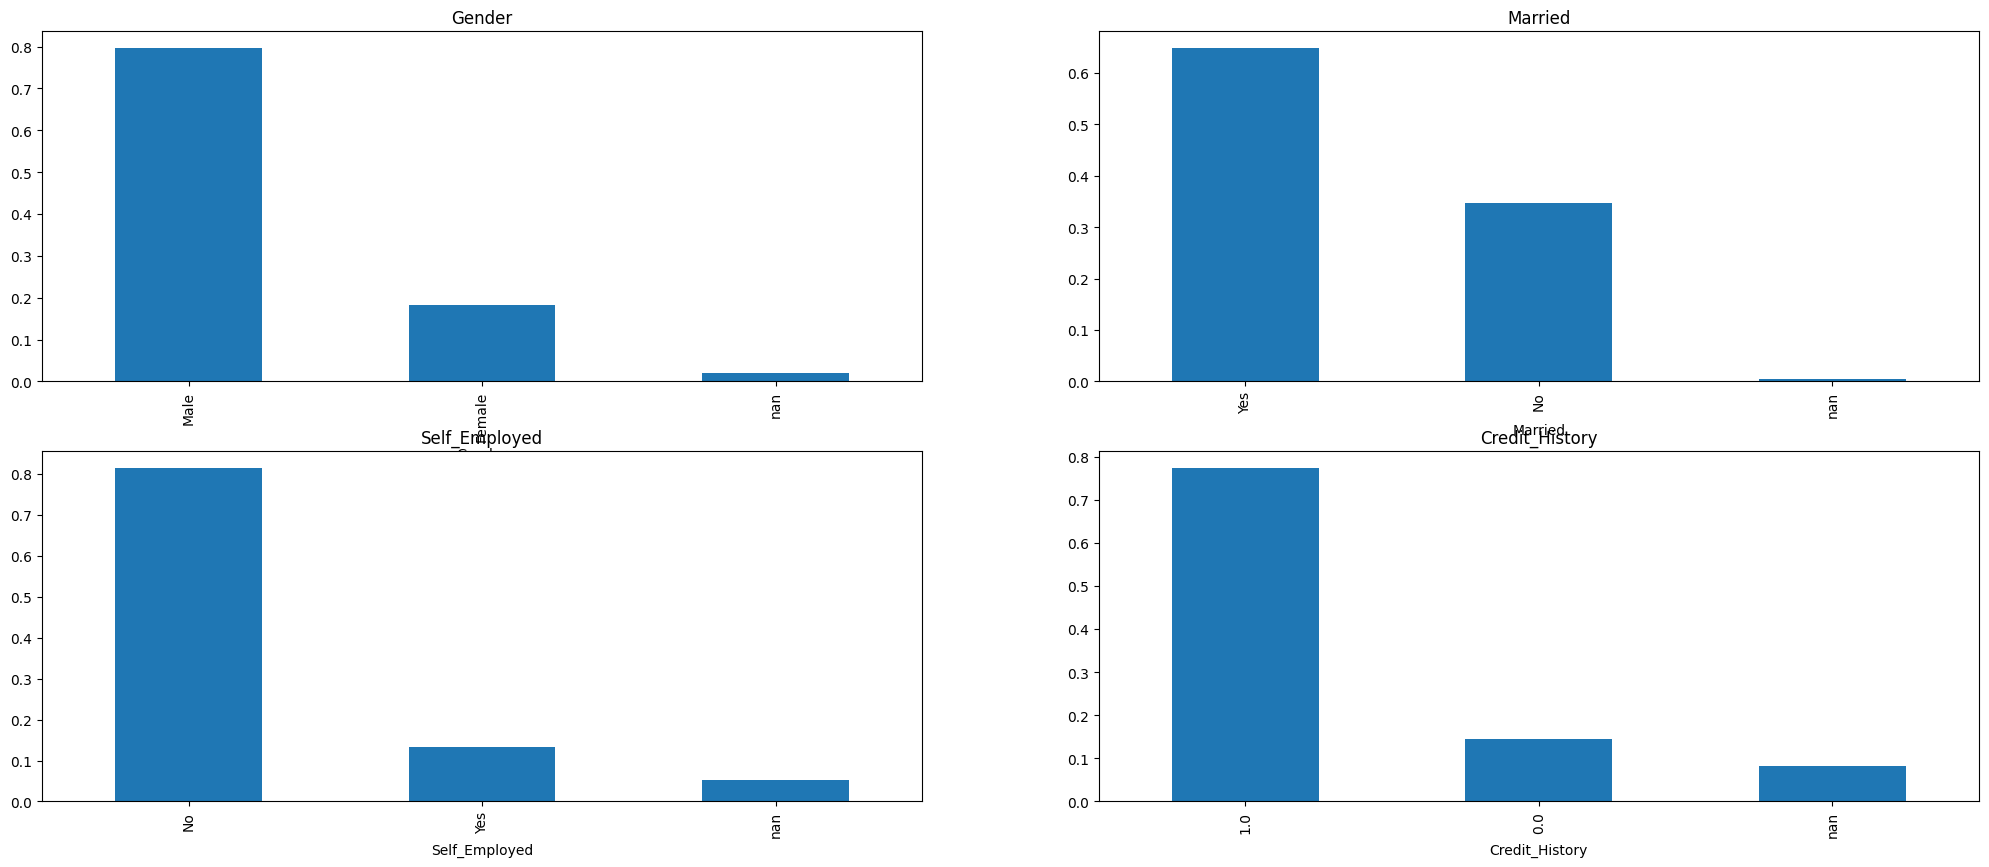

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(25, 10))
df_train['Gender'].value_counts(normalize=True, dropna=False).plot.bar(figsize=(25,10), title= 'Gender', ax=axes[0,0])
df_train['Married'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Married', ax=axes[0,1])
df_train['Self_Employed'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Self_Employed', ax=axes[1,0])
df_train['Credit_History'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Credit_History', ax=axes[1,1])
plt.show()

It can be inferred from the above bar plots that:

- 80% of the applicants are male
- 65% of the applicants are married
- 15% of the applicants are self employed
- 85% of the applicants have repaid the debts

#### Independent variable (Ordinal)

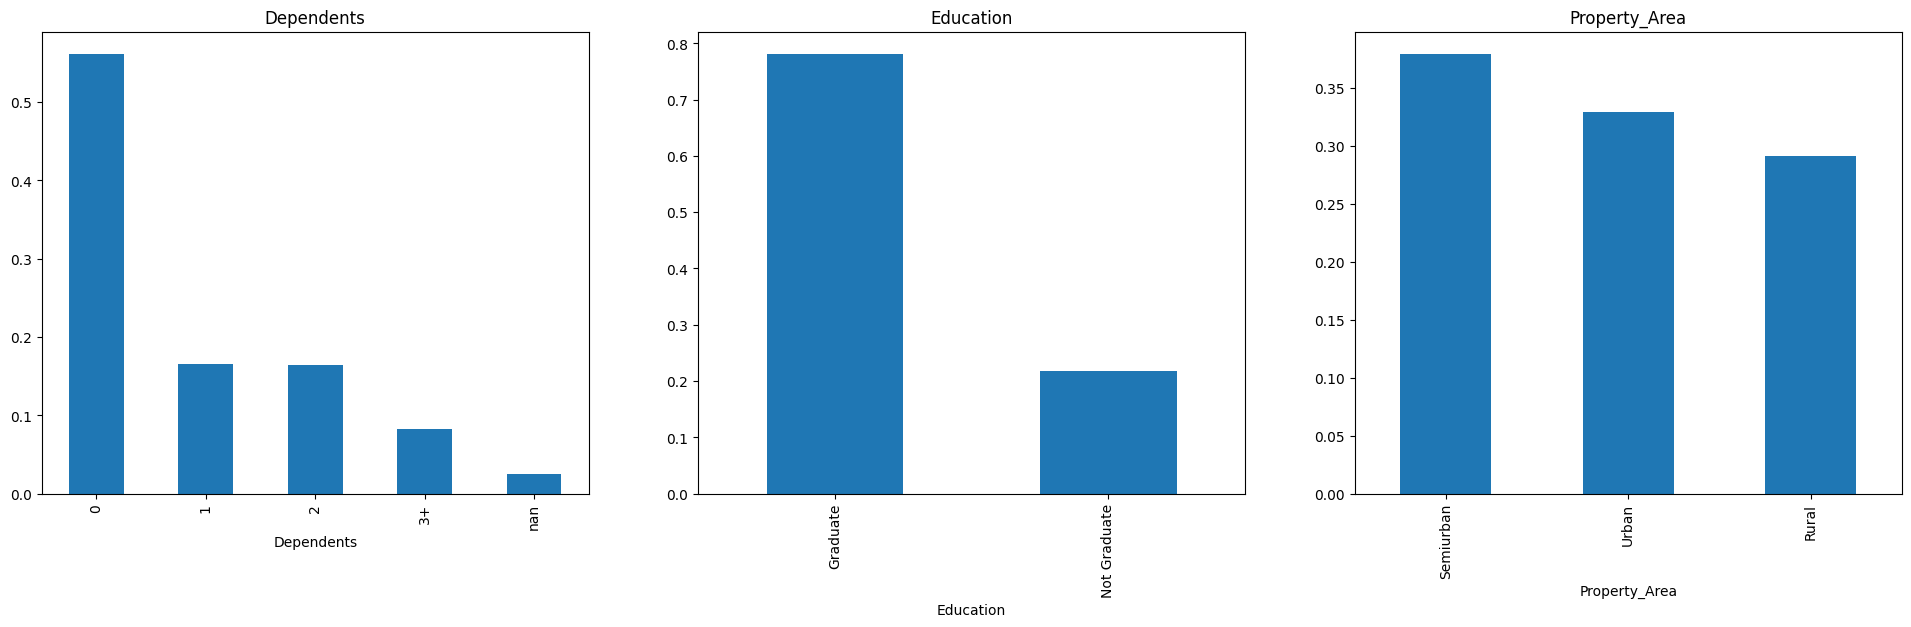

In [10]:
fig, axes = plt.subplots(1,3, figsize=(24, 6))
df_train['Dependents'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Dependents', ax=axes[0])
df_train['Education'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Education', ax=axes[1])
df_train['Property_Area'].value_counts(normalize=True, dropna=False).plot.bar(title= 'Property_Area', ax=axes[2])
plt.show()

Following inferences can be made from the above bar charts

- Most of the applicants don't have any dependents
- ~80% of the applicants are graduate.
- Most of the applicants are from Semiurban area

#### Independent variable (Numerical)

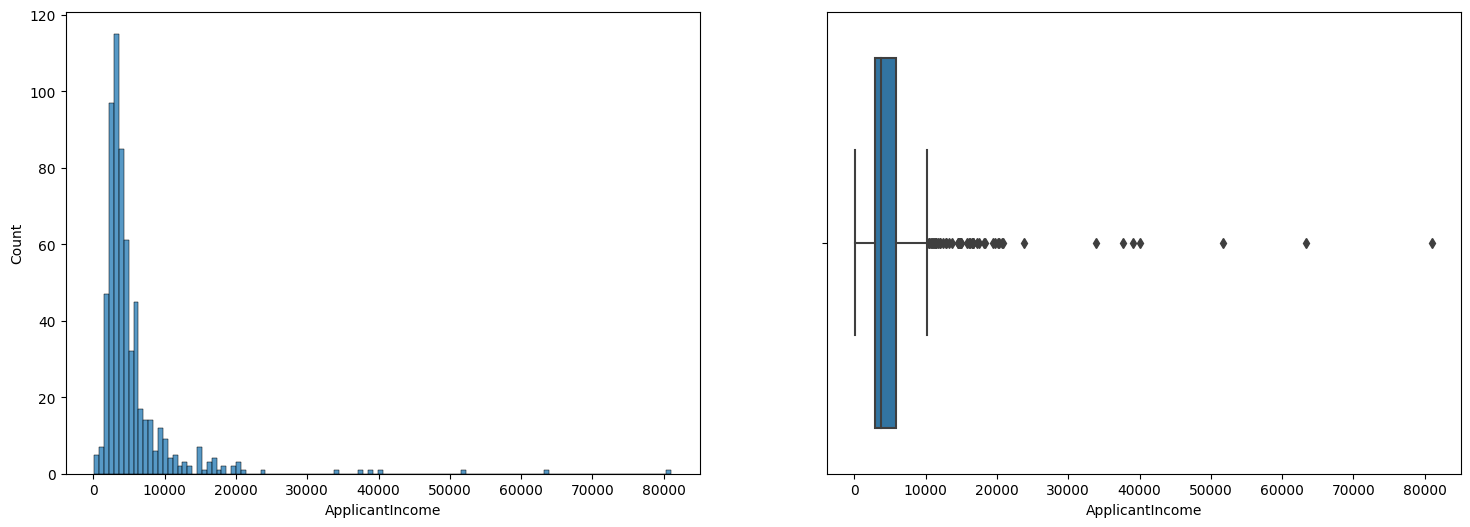

In [11]:
# Applicant Income
fig, axes = plt.subplots(1,2, figsize=(18,6))
sns.histplot(df_train['ApplicantIncome'], ax=axes[0])
sns.boxplot(df_train, x='ApplicantIncome', ax=axes[1])
plt.show()

It can be inferred that most the data in the distribution is towards left which means it is not normally distributed. We will try to make it normal later algorithm works better if the data is normally distributed.

The box plot confirms the presence of outliers/extreme values. This an be attributed to income disparity in the society. 
Part of this can be driven by the fact that we are looking at people with different education levels.

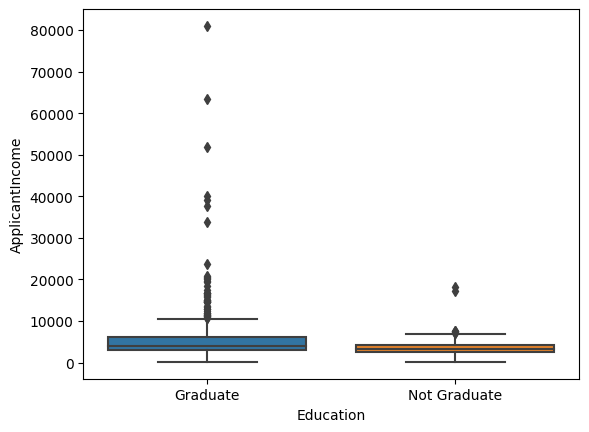

In [12]:
sns.boxplot(data=df_train, x='Education', y='ApplicantIncome')
plt.show()

We can see that there are higher number of graduates with very high incomes, which are appearing to be the outliers.

<Axes: xlabel='CoapplicantIncome'>

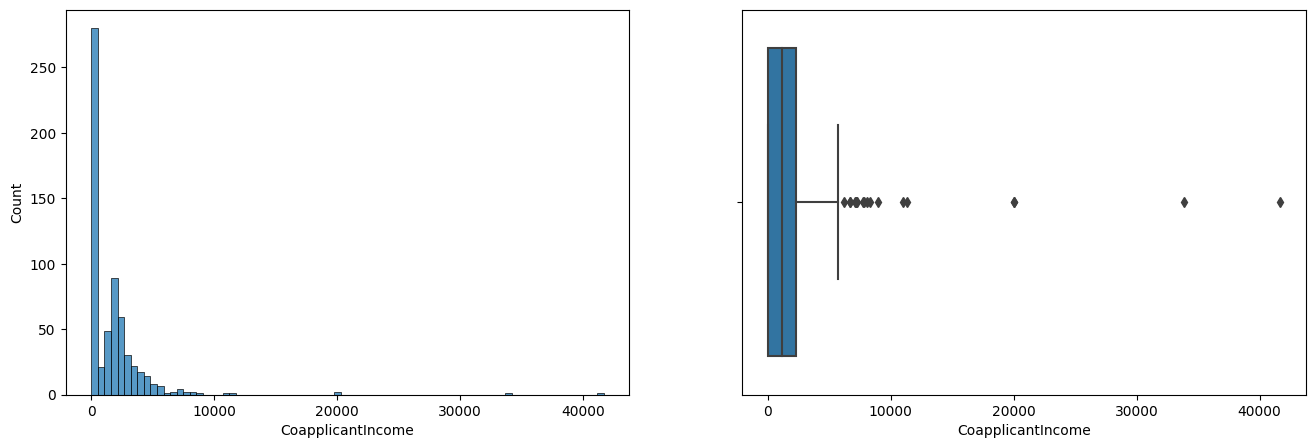

In [13]:
# Co-applicant Income
fig, axes = plt.subplots(1,2, figsize=(16, 5))
sns.histplot(df_train['CoapplicantIncome'], ax=axes[0])
sns.boxplot(data=df_train, x='CoapplicantIncome', ax=axes[1])

We see similar distribution as that of the applicant income. Majority ofn coapplicant's income ranges from 0 to 5000. We also see a lot of outliers in the co-applicant income and it is not normally distributed.

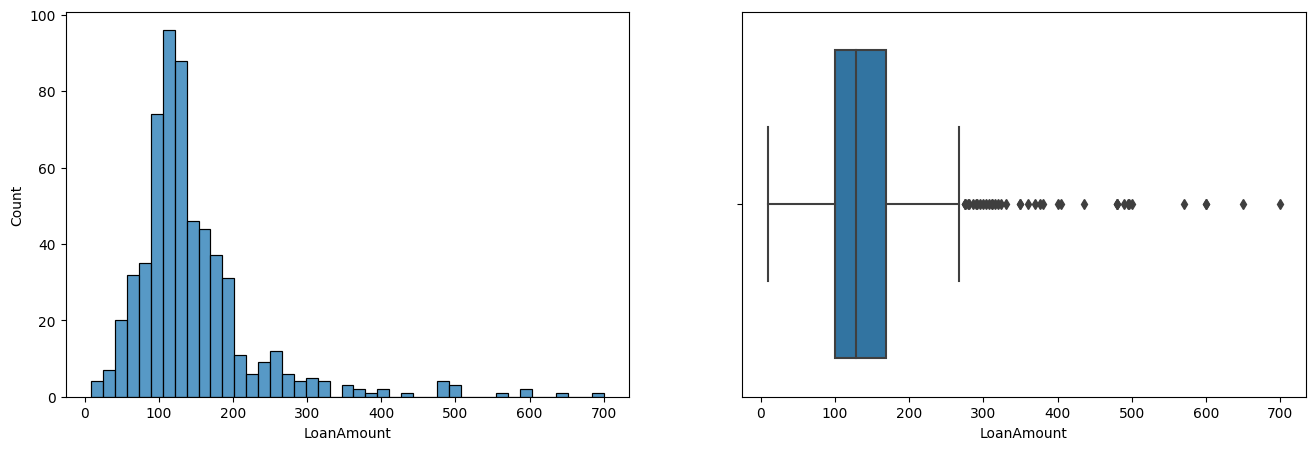

In [14]:
# Loan Amount
fig, axes = plt.subplots(1,2, figsize=(16, 5))
sns.histplot(df_train['LoanAmount'], ax=axes[0])
sns.boxplot(df_train, x='LoanAmount',ax=axes[1])
plt.show()

We see a lot of outliers in this variable and distribution is not normal

Now we would like to know how well each feature correlate with target variable (Loan Status)

### EDA - Bivariate Analysis

#### Categorical Independent Variable vs Target Variable

Text(0, 0.5, 'Proportion')

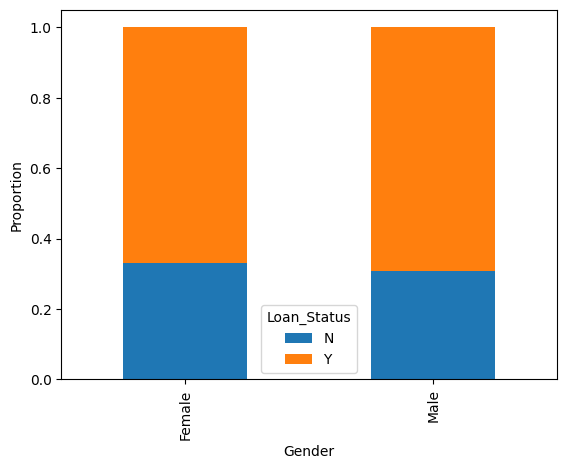

In [15]:
# Gender
Gender_tab = pd.crosstab(df_train['Gender'], df_train['Loan_Status'])
Gender_tab.div(Gender_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.ylabel('Proportion')

It can be inferred that the proportion of male and female applicants is more or less same for both approved and unapproved loans.

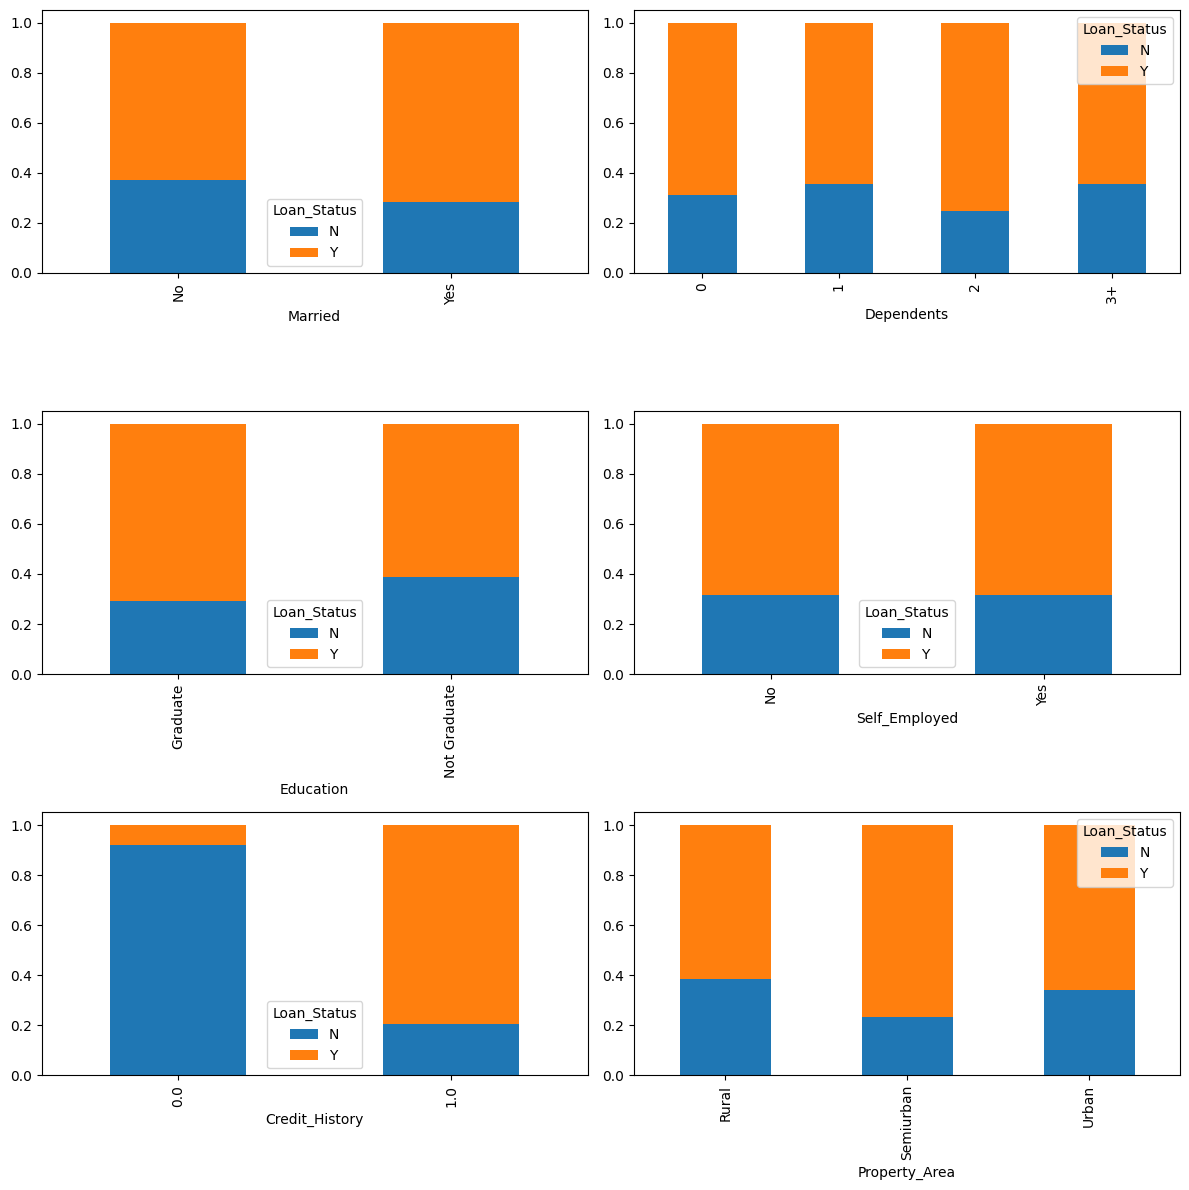

In [16]:
# Visualize the remaining categorical variables vs target variable
Married_tab = pd.crosstab(df_train['Married'], df_train['Loan_Status'])
Dependents_tab = pd.crosstab(df_train['Dependents'], df_train['Loan_Status'])
Education_tab = pd.crosstab(df_train['Education'], df_train['Loan_Status'])
Self_Employed_tab = pd.crosstab(df_train['Self_Employed'], df_train['Loan_Status'])
Credit_History_tab = pd.crosstab(df_train['Credit_History'], df_train['Loan_Status'])
Property_Area_tab = pd.crosstab(df_train['Property_Area'], df_train['Loan_Status'])

fig, axes = plt.subplots(3, 2,figsize=(12, 12))
Married_tab.div(Married_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[0, 0])
Dependents_tab.div(Dependents_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[0, 1])
Education_tab.div(Education_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[1, 0])
Self_Employed_tab.div(Self_Employed_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[1, 1])
Credit_History_tab.div(Credit_History_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[2, 0])
Property_Area_tab.div(Property_Area_tab.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes[2, 1])
plt.tight_layout()
plt.show()

- Proportion of married applicants is higher for approved loan.
- Distribution of 1 and 3+ is similar across both the categories of Loan_Status.
- graduates have higher chances of getting their loans approved.
- There is nothing significant we can infer from Self_Employed vs Loan_Status.
- It seems applicants with credit history as 1 are more likely to get their loans approved.
- Proportion of loans getting approved for semiurban is higher as compared to urban or rural areas.   

#### Numerical Independent Variable vs Target Variable

We'll try to find out the mean income of applicants for which the loan has been approved vs the mean income of applicants for which the loan has not been approved.

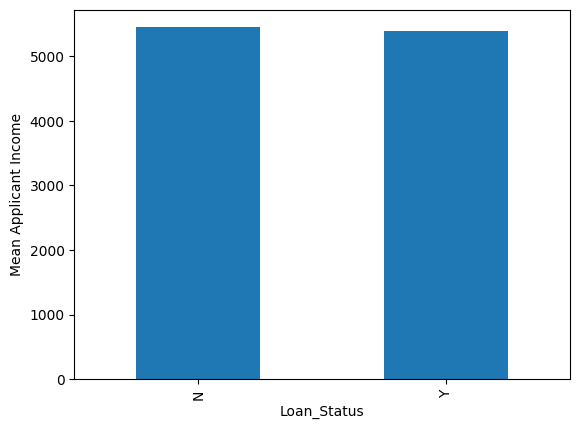

In [23]:
df_train.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar()
plt.ylabel('Mean Applicant Income')
plt.show()

We dont see any change in the mean applicant income. So let's make bins for the applicant income variable based on values in it and analyze the corresponding Loan status for each bin.
